In [18]:
%pip install pandas
%pip install darts

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Imports

In [19]:
import pandas as pd
from darts import TimeSeries
from darts.utils.model_selection import train_test_split
import numpy as np
import warnings
from darts import concatenate
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode
import matplotlib.pyplot as plt
from darts.metrics import rmse, r2_score
from darts.models import NBEATSModel, XGBModel, LinearRegressionModel
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.dataprocessing.transformers import Mapper, Scaler


warnings.filterwarnings("ignore")


random_state = 42
np.random.seed(random_state)
END_DATE = pd.Timestamp("2025-05-31")

In [20]:
def RemoveOutliers(df, column):
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to exclude outliers
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df


In [21]:
purchase_orders = pd.read_csv("./data/kernel/purchase_orders.csv")
purchase_orders = purchase_orders[purchase_orders["status"] == "Closed"]

purchase_orders["delivery_date"] = (
    pd.to_datetime(purchase_orders["delivery_date"], utc=True)
    .dt.tz_localize(None)
    .dt.normalize()
)

purchase_orders["created_date_time"] = (
    pd.to_datetime(purchase_orders["created_date_time"], utc=True)
    .dt.tz_localize(None)
    .dt.normalize()
)

purchase_orders.head()

,purchase_order_id,purchase_order_item_no,quantity,delivery_date,product_id,product_version,created_date_time,modified_date_time,unit_id,unit,status_id,status
0,1,1,-14.0,2003-05-11,91900143,1,2003-05-12,2004-06-15 06:16:18.0000000 +00:00,NaN,NaN,2,Closed
1,22,1,23880.0,2003-05-26,91900160,1,2003-05-27,2012-06-29 09:41:13.0000000 +00:00,NaN,NaN,2,Closed
2,41,1,0.0,2004-03-07,91900143,1,2004-03-08,2012-07-04 13:51:02.0000000 +00:00,NaN,NaN,2,Closed
3,61,1,0.0,2004-03-09,91900143,1,2004-03-10,2012-07-04 13:50:59.0000000 +00:00,NaN,NaN,2,Closed
4,141,10,25000.0,2004-10-27,91900143,1,2004-10-22,2012-07-04 13:50:55.0000000 +00:00,NaN,NaN,2,Closed


In [22]:
receivals = pd.read_csv("data/kernel/receivals.csv")
len(receivals)

receivals = receivals.dropna(subset=["net_weight"])
receivals = receivals[receivals["net_weight"] > 0]
receivals = receivals.dropna(subset=["rm_id"])
receivals["rm_id"] = receivals["rm_id"].astype(int)


print("Drop rows where net_weight is NaN or <= 0:", len(receivals))

receivals["date_arrival"] = (
    pd.to_datetime(receivals["date_arrival"], utc=True)
    .dt.tz_localize(None)
    .dt.normalize()
)

receivals = receivals.merge(
    purchase_orders,
    how="left",
    on=["purchase_order_id", "purchase_order_item_no"],
)

# receivals = receivals[receivals["date_arrival"] > pd.Timestamp("2020-01-01")]

daily_receivals = (
    receivals.groupby(["rm_id", "date_arrival"], as_index=False)
    .agg(
        net_weight_sum=("net_weight", "sum"),
        net_weight_mean=("net_weight", "mean"),
        num_receivals=("net_weight", "count"),
        total_order_qty=("quantity", "sum"),
        avg_order_qty=("quantity", "mean"),
    )
    .fillna(0)
    .rename(columns={"date_arrival": "date", "net_weight_sum": "net_weight"})
    .sort_values(["rm_id", "date"])
)
print(len(daily_receivals))

# Letztes Lieferdatum pro rm_id berechnen
last_dates = daily_receivals.groupby("rm_id")["date"].max()
first_dates = daily_receivals.groupby("rm_id")["date"].min()

# IDs, muessen mindestens 40 Tage zwischen erster und letzter Lieferung haben
valid_rm_ids = first_dates.index[(last_dates - first_dates).dt.days >= 40]
daily_receivals = daily_receivals[
    daily_receivals["rm_id"].isin(valid_rm_ids)
].reset_index(drop=True)

# IDs, deren letzte Lieferung älter als 365 Tage ist
cutoff_date = pd.Timestamp("2025-01-01") - pd.Timedelta(days=60)
old_rm_ids = last_dates[last_dates < cutoff_date].index

print(f"Skipping {len(old_rm_ids)} rm_ids (last entry before {cutoff_date.date()}):")
print(old_rm_ids.tolist())

# Entferne diese IDs aus dem DataFrame
daily_receivals = daily_receivals[
    ~daily_receivals["rm_id"].isin(old_rm_ids)
].reset_index(drop=True)

print("Length of daily_receivals after dropping old rm_id:", len(daily_receivals))


stats = daily_receivals.groupby("rm_id").agg(
    last_delivery=("date", "max"),
    total_deliveries=("date", "count"),  # number of delivery-days
    total_order_qty=("total_order_qty", "sum"),
    avg_order_qty=("avg_order_qty", "mean"),
)
cutoff = pd.Timestamp("2024-12-31") - pd.DateOffset(years=5)

rare_rm_id = stats.index[
    (stats["last_delivery"] <= cutoff) | (stats["total_deliveries"] <= 10)
]

print(
    f"We don't have enough information to forecast the following rm_id :\n{rare_rm_id}"
)
# I remove rare_rm_id
daily_receivals = daily_receivals[
    ~daily_receivals["rm_id"].isin(rare_rm_id)
].reset_index(drop=True)

rm_ids = daily_receivals["rm_id"].unique().tolist()


print("Length of daily_receivals after filtering rare rm_id:", len(daily_receivals))

daily_receivals = RemoveOutliers(daily_receivals, "net_weight")
print("Length of daily_receivals after removing outliers:", len(daily_receivals))


Drop rows where net_weight is NaN or <= 0: 122383
41906
Skipping 170 rm_ids (last entry before 2024-11-02):
[342, 343, 345, 346, 347, 348, 353, 354, 355, 357, 358, 360, 362, 364, 365, 366, 367, 368, 369, 374, 375, 378, 379, 380, 381, 383, 386, 387, 388, 389, 390, 1842, 1843, 1844, 1845, 1846, 1850, 1851, 1852, 1853, 1854, 1857, 1858, 1866, 1867, 1868, 1871, 1872, 1873, 1874, 1875, 1876, 1882, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1981, 1982, 2001, 2061, 2102, 2121, 2122, 2123, 2124, 2127, 2128, 2138, 2139, 2140, 2141, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2182, 2201, 2222, 2223, 2261, 2282, 2283, 2284, 2285, 2302, 2304, 2322, 2323, 2341, 2343, 2344, 2345, 2347, 2348, 2362, 2363, 2364, 2365, 2401, 2402, 2421, 2441, 2481, 2482, 2521, 2561, 2601, 2742, 2761, 2821, 2841, 2861, 2981, 3005, 3022, 3101, 3121, 3142, 3144, 3161, 3162, 3201, 3222, 3241, 3265, 3441, 3461, 3481, 3501, 3541, 3581, 3601, 3621, 3642, 3761, 3762, 3802

In [23]:
# build full index. one timestamp for each day for each rm_id
full_start = daily_receivals["date"].min()
print("Full start date:", full_start)
full_end = pd.Timestamp("2024-12-31")
rm_ids = pd.Index(daily_receivals["rm_id"].unique(), name="rm_id")
calendar = pd.date_range(full_start, full_end, freq="D", name="date")
full_idx = pd.MultiIndex.from_product([rm_ids, calendar], names=["rm_id", "date"])
print(len(full_idx))
daily_receivals = (
    daily_receivals.set_index(["rm_id", "date"])
    .reindex(full_idx, fill_value=0)
    .reset_index()
)

print(len(daily_receivals))

Full start date: 2011-11-14 00:00:00
134316
134316


In [24]:
stats

,last_delivery,total_deliveries,total_order_qty,avg_order_qty
rm_id,,,,
2125,2024-12-02,129,1.404700e+05,1051.562016
2129,2024-12-19,214,6.278284e+06,24171.498442
2130,2024-12-19,2940,1.004656e+10,467826.640048
2131,2024-12-11,1518,1.144175e+08,53623.844631
2132,2024-12-17,1735,1.001907e+08,33233.096953
2133,2024-11-22,690,5.061878e+07,63579.935024
2134,2024-12-19,1787,1.161781e+08,44847.389237
2135,2024-12-18,1562,1.094714e+08,46892.854706
2142,2024-12-19,2312,2.133220e+08,46871.144149


In [25]:
receivals.groupby(["rm_id", "date_arrival"])["supplier_id"].nunique()

rm_id  date_arrival
342    2004-06-23      1
343    2005-03-29      1
345    2004-09-01      1
346    2004-06-24      1
       2004-06-30      1
                      ..
4463   2024-10-17      1
4481   2024-10-29      1
       2024-11-27      1
4501   2024-12-02      1
       2024-12-09      1
Name: supplier_id, Length: 41906, dtype: int64

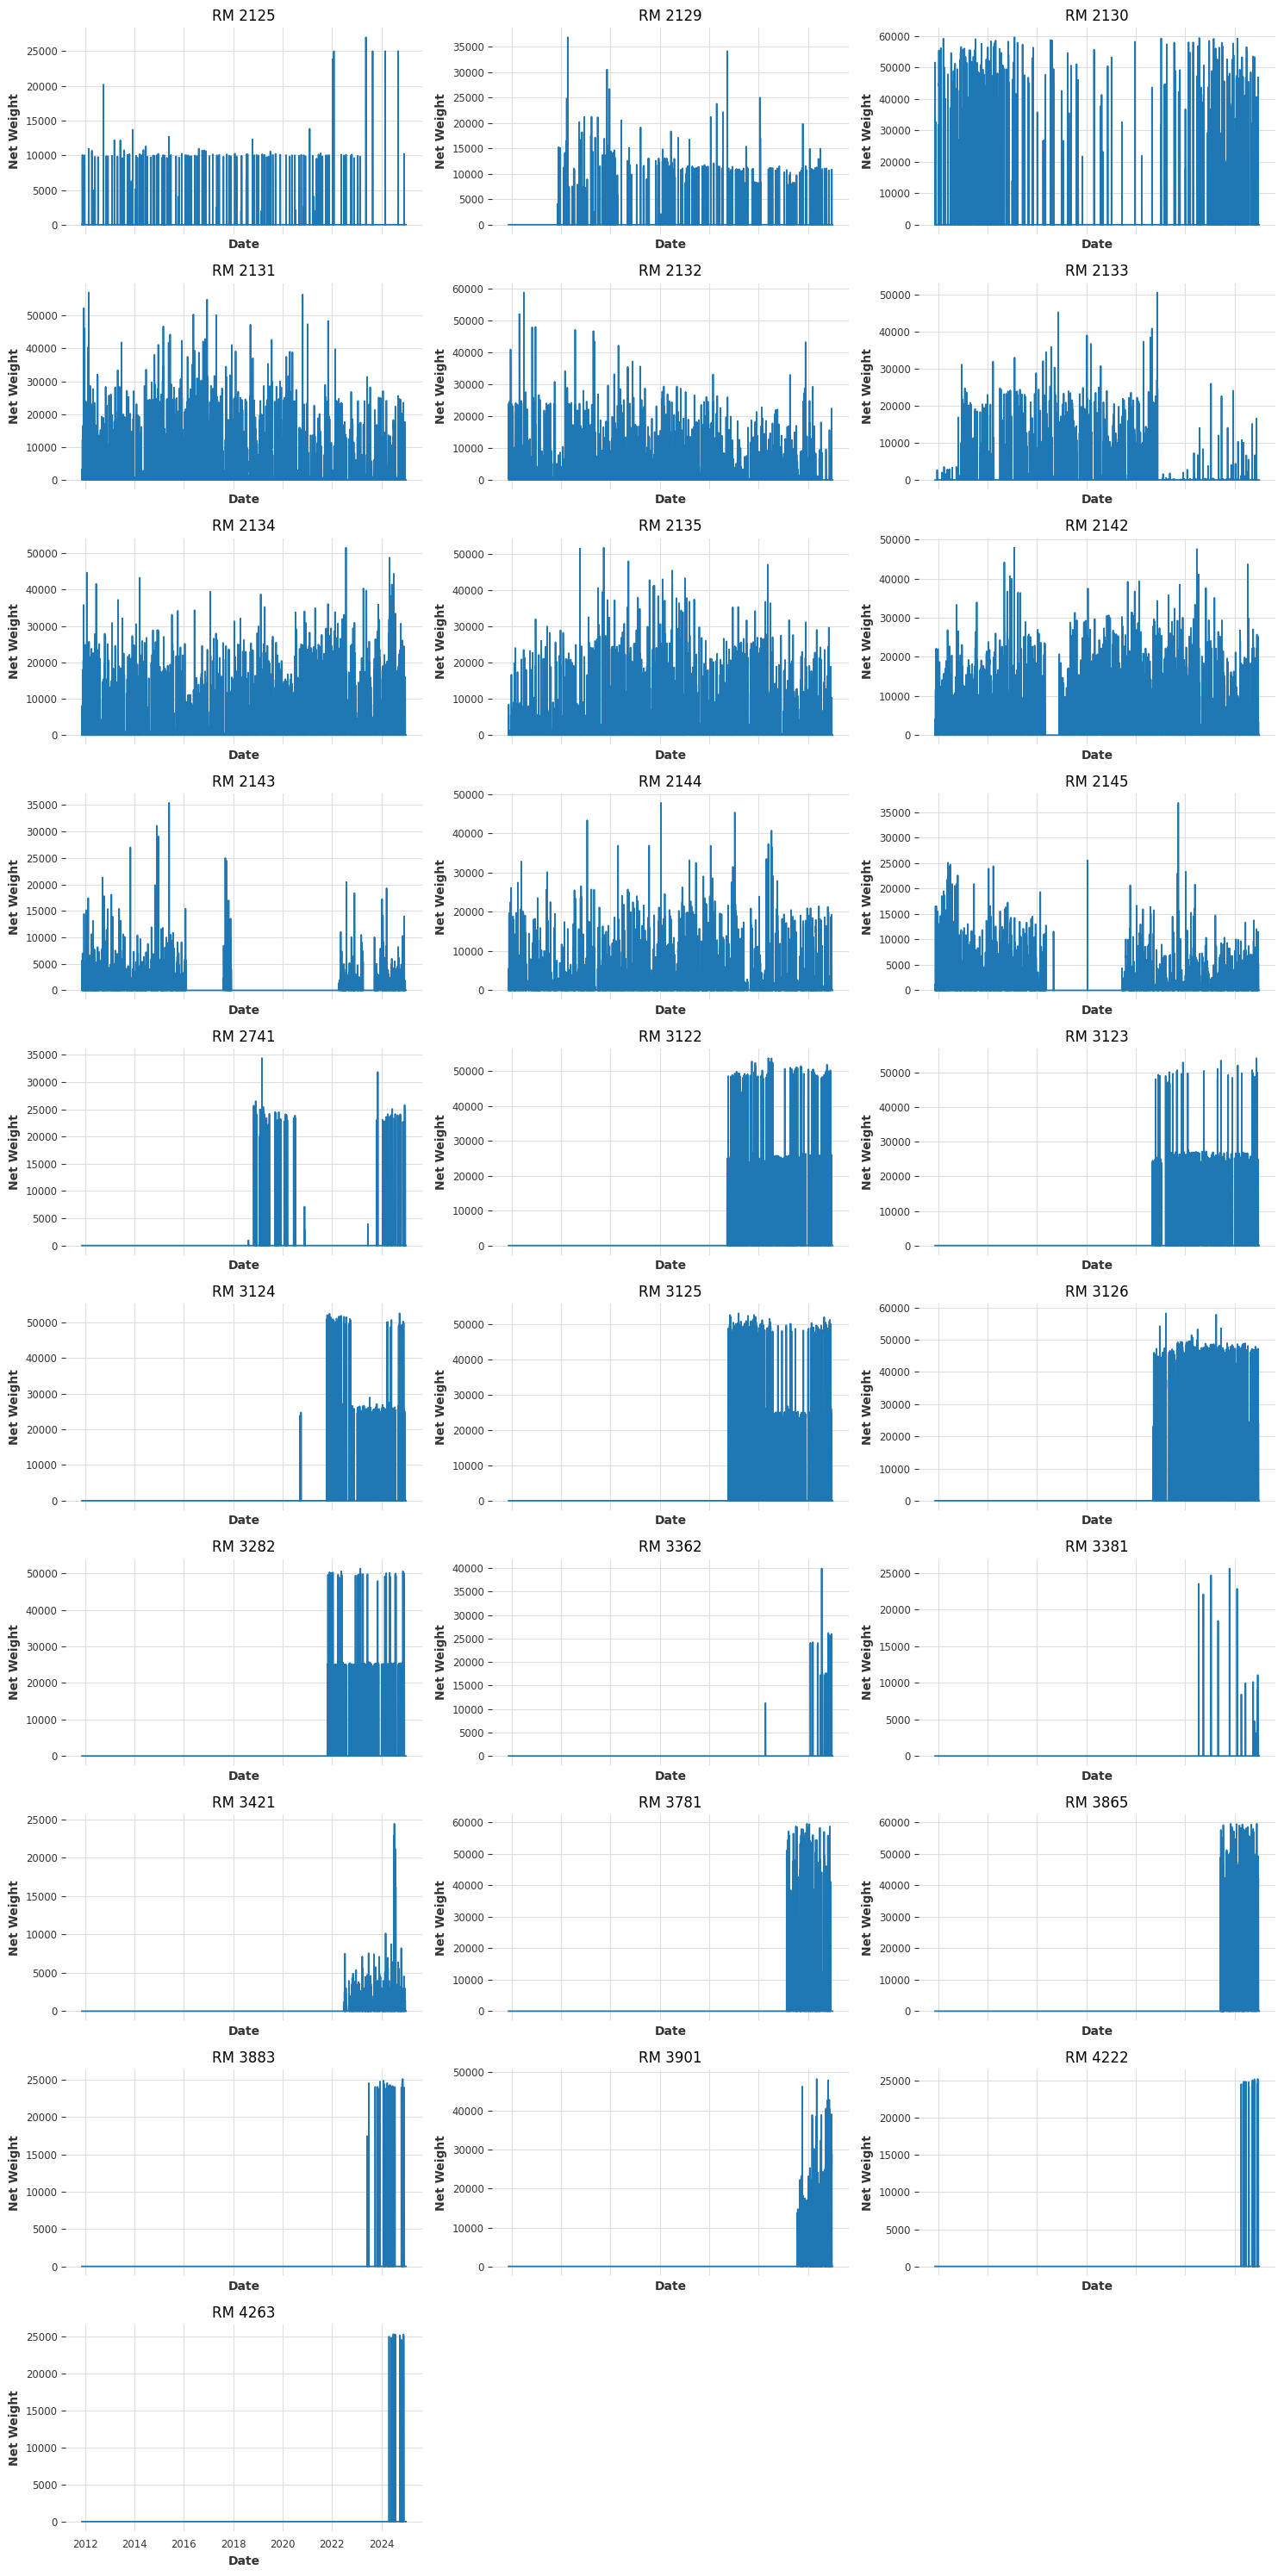

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Sicherstellen, dass 'date' im richtigen Format ist
daily_receivals["date"] = pd.to_datetime(daily_receivals["date"])

# Gruppieren nach rm_id
groups = []
for rm_id, group in daily_receivals.groupby("rm_id"):
    delta = pd.Timestamp("2025-01-01") - group["date"].max()
    groups.append((rm_id, group.sort_values("date")))

# Dynamische Subplot-Anzahl
n = len(groups)
ncols = 3  # kannst du anpassen (z. B. 2 oder 4)
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * nrows), sharex=True)
axes = axes.flatten()  # für einfaches Iterieren

for ax, (rm_id, group) in zip(axes, groups):
    ax.plot(group["date"], group["net_weight"], color="tab:blue")
    ax.set_title(f"RM {rm_id}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Net Weight")

# Leere Subplots ausblenden (falls mehr Zellen als Gruppen)
for ax in axes[len(groups) :]:
    ax.axis("off")

plt.tight_layout()
plt.show()


## Create time series

In [27]:
series_lst = TimeSeries.from_group_dataframe(
    daily_receivals,
    "rm_id",
    "date",
    "net_weight",
    freq="D",
    fill_missing_dates=True,
    fillna_value=0.0,
)

# for i, s in enumerate(series_lst):
#     rm_id = (
#         s.static_covariates["rm_id"].values[0]
#         if s.static_covariates is not None
#         else rm_ids[i]
#     )
#     stats_for_rm = stats[stats.index == rm_id]
#     series_lst[i] = s.with_static_covariates(stats_for_rm)

print(len(series_lst), len(series_lst[0]))

28 4797


In [28]:
covariate_cols = [
    # "num_receivals",
    "net_weight_mean",
    # "total_order_qty",
    # "avg_order_qty",
]

covariate_series = TimeSeries.from_group_dataframe(
    daily_receivals,
    "rm_id",
    "date",
    covariate_cols,
    freq="D",
    fill_missing_dates=True,
    fillna_value=0.0,
)

In [29]:
trend_and_seasonality = []
for i, series in enumerate(series_lst):
    # Extract trend and seasonal components
    if len(series) < 2 * 7:
        print(f"Series {i} is too short for trend/seasonality extraction.")
        # Platzhalter erstellen
        trend_placeholder = TimeSeries.from_times_and_values(
            series.time_index, np.zeros((len(series), 1)), columns=["trend"]
        )
        seasonal_placeholder = TimeSeries.from_times_and_values(
            series.time_index, np.zeros((len(series), 1)), columns=["seasonal"]
        )
        trend_and_seasonality.append((trend_placeholder, seasonal_placeholder))
        continue

    trend, seasonal = extract_trend_and_seasonality(
        series, freq=7, model=ModelMode.ADDITIVE
    )
    trend = trend.with_columns_renamed("net_weight", "trend")
    seasonal = seasonal.with_columns_renamed("net_weight", "seasonal")

    trend_and_seasonality.append((trend, seasonal))

print(len(trend_and_seasonality), len(trend_and_seasonality[0][0]))

28 4797


In [30]:
from darts.dataprocessing.transformers import WindowTransformer

# Extract mean of last seven days from series
transformer = WindowTransformer(
    transforms={"function": "mean", "mode": "rolling", "window": 7}, treat_na=0
)
mean_7_days = transformer.transform(series_lst)

transformer = WindowTransformer(
    transforms={"function": "mean", "mode": "rolling", "window": 30}, treat_na=0
)
mean_30_days = transformer.transform(series_lst)

transformer = WindowTransformer(
    transforms={"function": "mean", "mode": "rolling", "window": 90}, treat_na=0
)
mean_90_days = transformer.transform(series_lst)

print(len(mean_7_days), len(mean_7_days[0]))

28 4797


In [31]:
past_covariates = []
for i, series in enumerate(series_lst):
    trend = trend_and_seasonality[i][0]
    seasonal = trend_and_seasonality[i][1]

    past_cov = concatenate(
        [
            trend,
            seasonal,
            # covariate_series[i],
        ],
        axis=1,
        ignore_static_covariates=True,
    )
    past_cov = past_cov.add_datetime_attribute("day_of_week")
    past_cov = past_cov.add_datetime_attribute("month")

    past_covariates.append(past_cov)


print(len(past_covariates), len(past_covariates[0]))

28 4797


## Train test split

In [32]:
test_size = 0.2

train_lst, val_lst = train_test_split(series_lst, axis=1, test_size=test_size)
train_past_covariates, val_past_covariates = train_test_split(
    past_covariates, axis=1, test_size=test_size
)

print("Num series in training set:", len(train_lst))
print("Num series in validation set:", len(val_lst))
print("Num past covariates in training set:", len(train_past_covariates))
print("Num past covariates in validation set:", len(val_past_covariates))
print("Num elements in train series:", len(train_lst[0]))
print("Num elements in past covariate series:", len(train_past_covariates[0]))
print("Num elements in val series:", len(val_lst[0]))
print("Num elements in val past covariate series:", len(val_past_covariates[0]))


Num series in training set: 28
Num series in validation set: 28
Num past covariates in training set: 28
Num past covariates in validation set: 28
Num elements in train series: 3838
Num elements in past covariate series: 3838
Num elements in val series: 959
Num elements in val past covariate series: 959


## Naive model

In [33]:
# model_dict = {}
# preds = []  # zum Speichern der Vorhersagen
# metrics = {"RMSE": [], "R2": []}  # pro Serie sammeln

# for n in range(len(train_lst)):
#     print(f"Training model for series {n + 1}/{len(train_lst)}")
#     print(f"Series length: {len(train_lst[n])} | Val length: {len(val_lst[n])}")

#     linear_model = LinearRegressionModel(
#         lags=32,
#         lags_past_covariates=24,
#         output_chunk_length=1,
#         random_state=random_state,
#     )
#     try:
#         linear_model.fit(
#             train_lst[n],
#             val_series=val_lst[n],
#             past_covariates=train_past_covariates[n],
#             val_past_covariates=val_past_covariates[n],
#             verbose=False,
#         )
#         model_dict[n] = linear_model
#     except Exception as e:
#         print(f"Error training model for series {n}: {e}")
#         continue

#     # Prediction
#     pred = linear_model.predict(
#         len(val_lst[n]),
#         series=train_lst[n],
#         past_covariates=past_covariates[n],
#     )
#     preds.append(pred)

#     # Evaluation pro Serie
#     rmse_val = rmse(val_lst[n], pred)
#     r2_val = r2_score(val_lst[n], pred)
#     metrics["RMSE"].append(rmse_val)
#     metrics["R2"].append(r2_val)

#     print(f"Series {n} | RMSE: {rmse_val:.2f} | R2: {r2_val:.3f}")

# # ==============================
# # Aggregierte Metriken ausgeben
# # ==============================
# print("\n=== Aggregated Metrics ===")
# print(f"Mean RMSE: {np.mean(metrics['RMSE']):.2f} | Std: {np.std(metrics['RMSE']):.2f}")
# print(f"Mean R2: {np.mean(metrics['R2']):.3f} | Std: {np.std(metrics['R2']):.3f}")

# # ==============================
# # Gemeinsame Subplots am Ende
# # ==============================
# n = len(preds)
# ncols = 3  # anpassen je nach gewünschter Breite
# nrows = (n + ncols - 1) // ncols

# fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * nrows), sharex=False)
# axes = axes.flatten()

# for i, ax in enumerate(axes):
#     if i >= len(preds):
#         ax.axis("off")
#         continue
#     train_lst[i].plot(ax=ax, label="Train", lw=1)
#     val_lst[i].plot(ax=ax, label="Actual", lw=1)
#     preds[i].plot(ax=ax, label="Linear Regression Forecast", lw=1.5, alpha=0.7)
#     ax.set_title(f"Series {i}")
#     ax.legend(fontsize=8)

# plt.tight_layout()
# plt.show()


### multiple series at once

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Series 28 | RMSE: [np.float64(1.7003117881957212e-08), np.float64(2.6450260609334242e-08), np.float64(2.0445911025788955e-07), np.float64(1.1204333242742799e-07), np.float64(5.619912612094785e-08), np.float64(1.0537743986170401e-08), np.float64(1.6344868154802918e-07), np.float64(1.3836092222961564e-07), np.float64(1.2698336764018917e-07), np.float64(2.463791891065484e-08), np.float64(1.3420040851642772e-07), np.float64(7.857516244921272e-08), np.float64(6.081188740557521e-08), np.float64(4.902758366165029e-07), np.float64(3.4138526727664435e-07), np.float64(4.231593825593752e-07), np.float64(5.248537125486653e-07), np.float64(5.010278751380715e-07), np.float64(2.9720221262795356e-07), np.float64(2.2012528696649055e-08), np.float64(3.9599618709783296e-08), np.float64(4.033544513908338e-08), np.float64(1.7634513359791925e-07), np.float64(2.34421845297018e-07), np.float64(2.037927026884289e-08), np.float64(6.989259671746655e-08), np.float64(1.6107097630706147e-08), np.float64(2.417877653

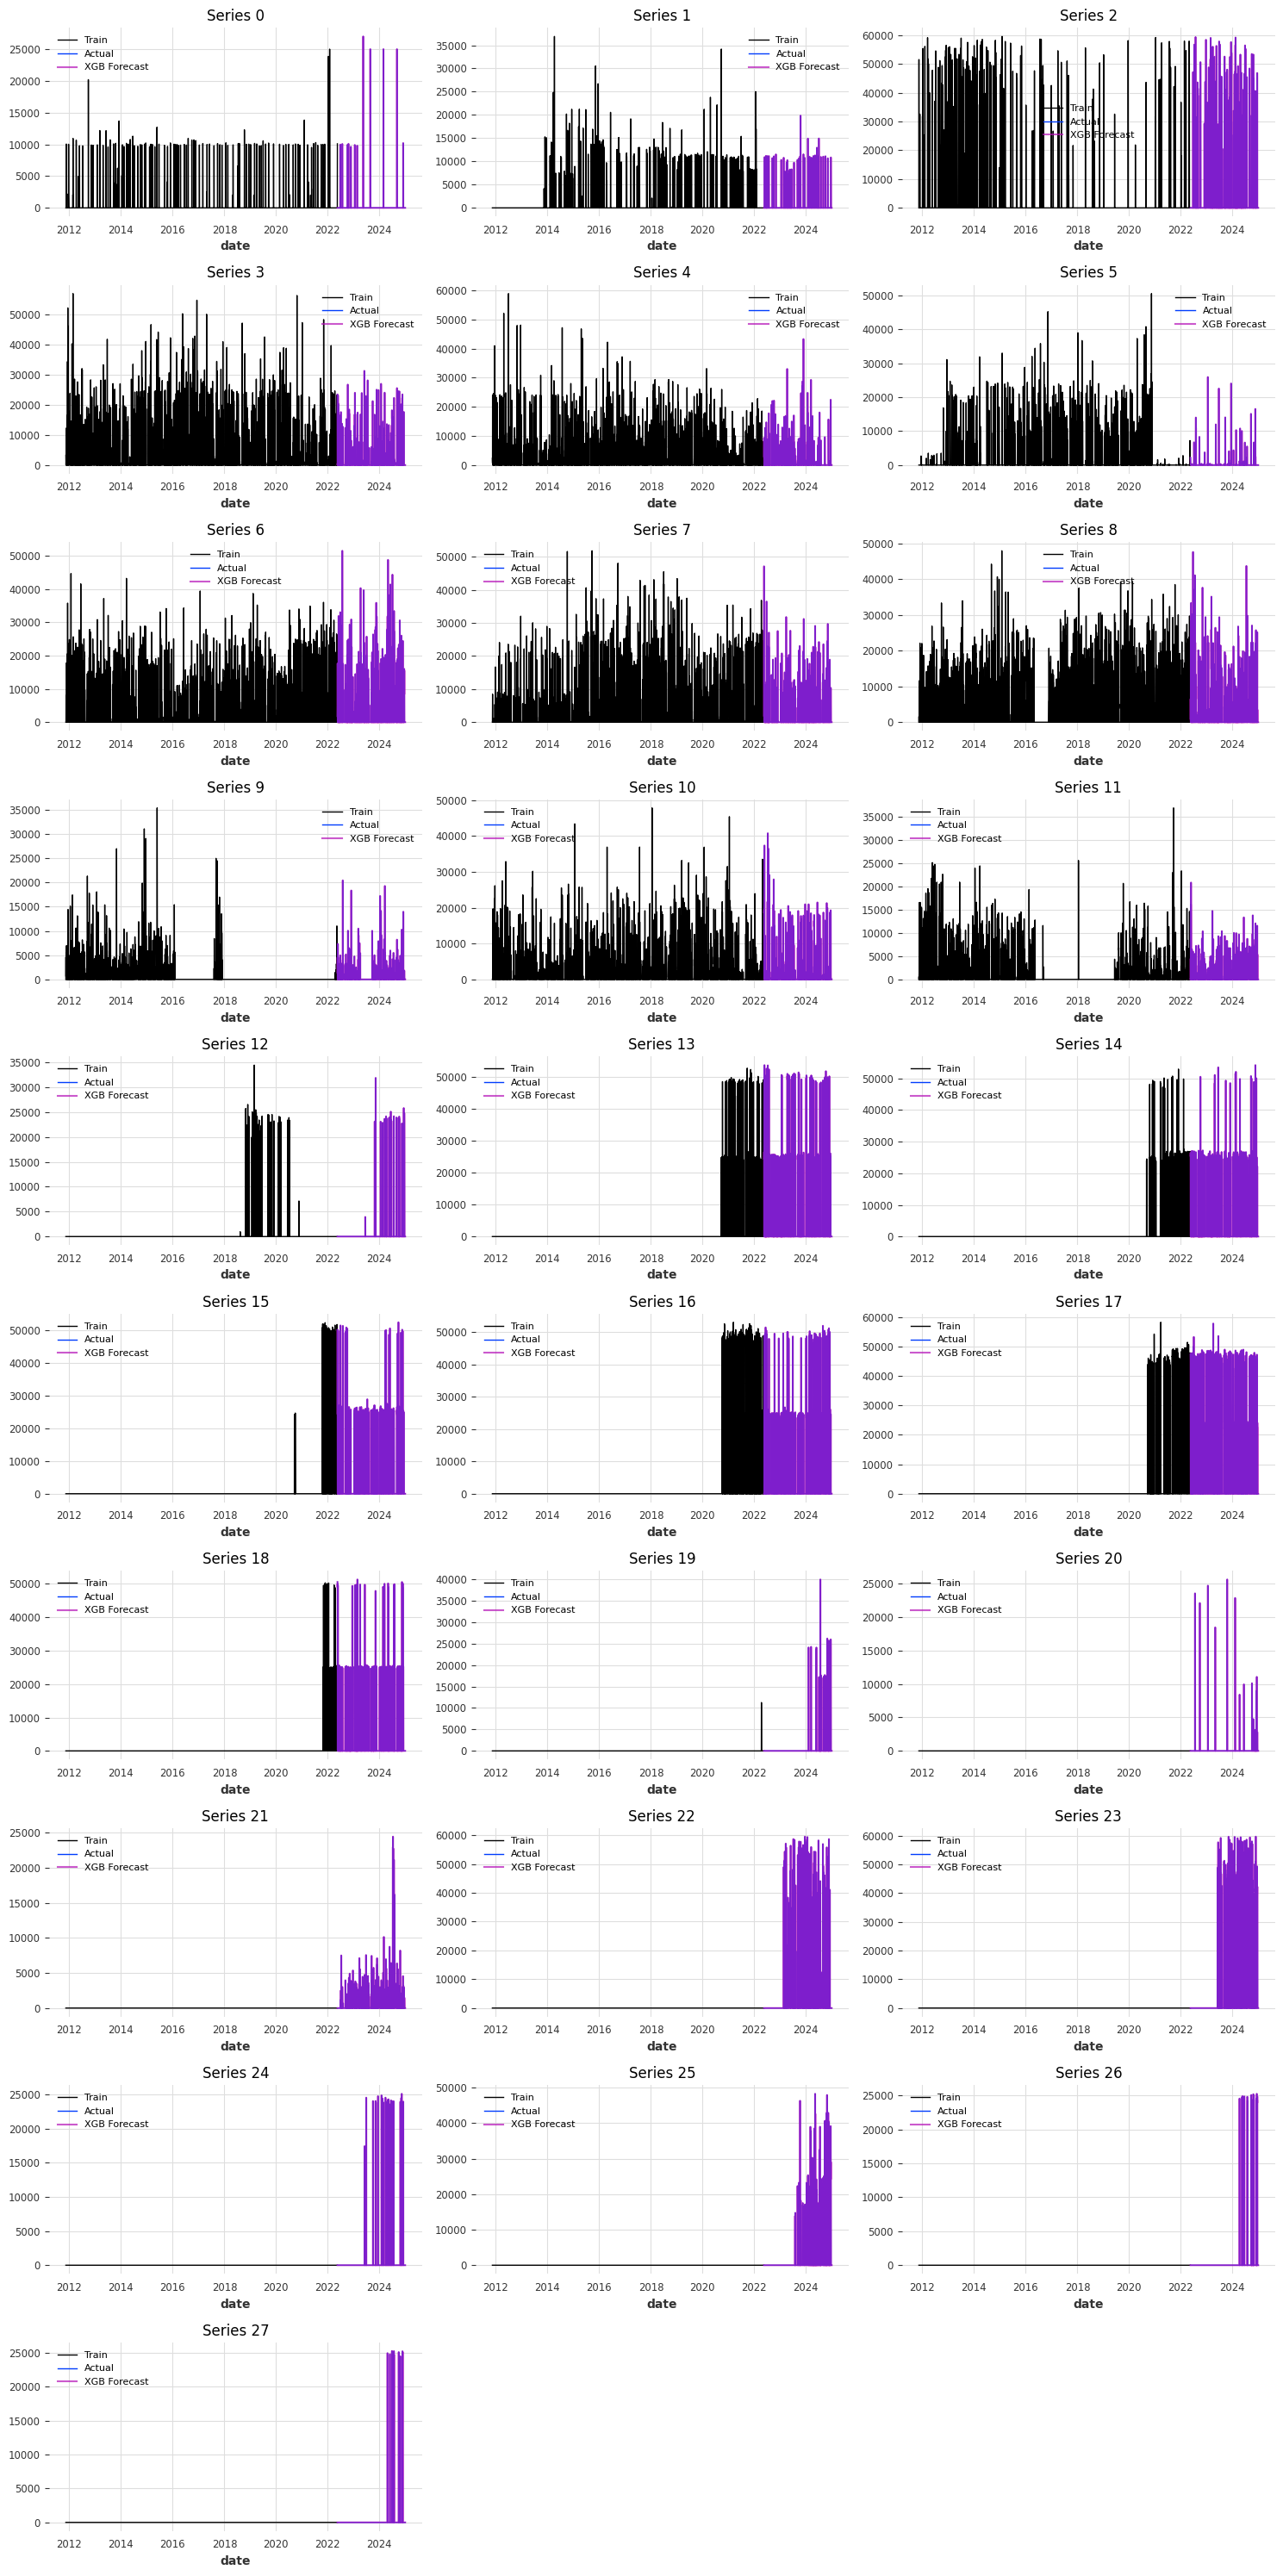

In [34]:
from darts.utils.callbacks import TFMProgressBar

preds = []

linear_model = LinearRegressionModel(
    lags=32,
    lags_past_covariates=24,
    output_chunk_length=1,
    random_state=random_state,
)

linear_model.fit(
    train_lst,
    val_series=val_lst,
    past_covariates=train_past_covariates,
    val_past_covariates=val_past_covariates,
    verbose=True,
)


preds = linear_model.predict(
    len(val_lst[0]),
    train_lst,
    past_covariates=past_covariates,
)

# Evaluation
print(f"Series {n} | RMSE: {rmse(val_lst, preds)} \n R2: {r2_score(val_lst, preds)}")

# ==============================
# Gemeinsame Subplots am Ende
# ==============================

n = len(preds)
ncols = 3  # anpassen je nach gewünschter Breite
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * nrows), sharex=False)
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(preds):
        ax.axis("off")
        continue
    train_lst[i].plot(ax=ax, label="Train", lw=1)
    val_lst[i].plot(ax=ax, label="Actual", lw=1)
    preds[i].plot(ax=ax, label="XGB Forecast", lw=1.5, alpha=0.7)
    ax.set_title(f"Series {i}")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


## Sirius models

In [35]:
# encoders = {
#     "cyclic": {"future": ["month"]},
#     "datetime_attribute": {"future": ["day_of_week"]},
# }

### XGB

In [36]:
# model_dict = {}
# preds = []  # zum Speichern der Vorhersagen
# metrics = {"RMSE": [], "R2": []}  # pro Serie sammeln

# for n in range(len(train_lst)):
#     print(f"Training model for series {n + 1}/{len(train_lst)}")
#     print(f"Series length: {len(train_lst[n])} | Val length: {len(val_lst[n])}")

#     model_xgb = XGBModel(
#         lags=32,
#         lags_past_covariates=32,
#         output_chunk_length=1,
#         early_stopping_rounds=50,
#         n_estimators=1000,
#         random_state=random_state,
#         # add_encoders=encoders,
#         multi_models=False,
#         n_jobs=-1,
#     )

#     try:
#         model_xgb.fit(
#             series=train_lst[n],
#             val_series=val_lst[n],
#             past_covariates=train_past_covariates[n],
#             val_past_covariates=val_past_covariates[n],
#             verbose=False,
#         )
#         model_dict[n] = model_xgb
#     except Exception as e:
#         print(f"Error training model for series {n}: {e}")
#         continue

#     # Prediction
#     pred = model_xgb.predict(
#         len(val_lst[n]),
#         series=train_lst[n],
#         past_covariates=past_covariates[n],
#     )
#     preds.append(pred)

#     # Evaluation pro Serie
#     rmse_val = rmse(val_lst[n], pred)
#     r2_val = r2_score(val_lst[n], pred)
#     metrics["RMSE"].append(rmse_val)
#     metrics["R2"].append(r2_val)

#     print(
#         f"Series {n}| trained for {model_xgb.model.best_iteration} epochs | RMSE: {rmse_val:.2f} | R2: {r2_val:.3f}"
#     )

# # ==============================
# # Aggregierte Metriken ausgeben
# # ==============================
# print("\n=== Aggregated Metrics ===")
# print(f"Mean RMSE: {np.mean(metrics['RMSE']):.2f} | Std: {np.std(metrics['RMSE']):.2f}")
# print(f"Mean R2: {np.mean(metrics['R2']):.3f} | Std: {np.std(metrics['R2']):.3f}")

# # ==============================
# # Gemeinsame Subplots am Ende
# # ==============================
# n = len(preds)
# ncols = 3  # anpassen je nach gewünschter Breite
# nrows = (n + ncols - 1) // ncols

# fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * nrows), sharex=False)
# axes = axes.flatten()

# for i, ax in enumerate(axes):
#     if i >= len(preds):
#         ax.axis("off")
#         continue
#     train_lst[i].plot(ax=ax, label="Train", lw=1)
#     val_lst[i].plot(ax=ax, label="Actual", lw=1)
#     preds[i].plot(ax=ax, label="XGB Forecast", lw=1.5, alpha=0.7)
#     ax.set_title(f"Series {i}")
#     ax.legend(fontsize=8)

# plt.tight_layout()
# plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from collections import defaultdict

# # Dictionary, um die Importances pro Feature zu sammeln
# agg_importances = defaultdict(list)

# # Alle Modelle durchlaufen
# for n, model in model_dict.items():
#     importances = model.model.feature_importances_
#     feature_names = model.lagged_feature_names
#     for fname, imp in zip(feature_names, importances):
#         agg_importances[fname].append(imp)

# # Mittelwert über alle Modelle
# mean_importances = {fname: np.mean(imps) for fname, imps in agg_importances.items()}

# # Nach Importance sortieren
# sorted_features = sorted(mean_importances.items(), key=lambda x: x[1], reverse=True)

# # Top 10 Features ausgeben
# print("Top 10 Features über alle Modelle:")
# for i, (fname, imp) in enumerate(sorted_features[:15]):
#     print(f"{i + 1}. Feature: {fname} | Mean Importance: {imp:.4f}")

# # Bottom 10 Features ausgeben
# print("Bottom 10 Features über alle Modelle:")
# for i, (fname, imp) in enumerate(sorted_features[-15:]):
#     print(f"{i + 1}. Feature: {fname} | Mean Importance: {imp:.4f}")

# # Plot aller Features
# features, importances = zip(*sorted_features)
# plt.figure(figsize=(12, 6))
# plt.bar(range(len(importances)), importances, color="skyblue")
# plt.xticks(range(len(importances)), features, rotation=90)
# plt.ylabel("Mean Feature Importance")
# plt.title("Aggregated XGB Feature Importances Across All Models")
# plt.tight_layout()
# plt.show()


NameError: name 'model_dict' is not defined

#### multiple series at once

[0]	validation_0-rmse:9001.69477
[1]	validation_0-rmse:7449.72087
[2]	validation_0-rmse:6438.54713
[3]	validation_0-rmse:5519.44861
[4]	validation_0-rmse:5064.74819
[5]	validation_0-rmse:4681.63388
[6]	validation_0-rmse:4450.79535
[7]	validation_0-rmse:4173.91926
[8]	validation_0-rmse:3874.50490
[9]	validation_0-rmse:3728.65123
[10]	validation_0-rmse:3513.72933
[11]	validation_0-rmse:3396.56498
[12]	validation_0-rmse:3329.22874
[13]	validation_0-rmse:3224.70016
[14]	validation_0-rmse:3163.66973
[15]	validation_0-rmse:3114.82826
[16]	validation_0-rmse:3093.13838
[17]	validation_0-rmse:3066.93848
[18]	validation_0-rmse:3026.37542
[19]	validation_0-rmse:3001.73552
[20]	validation_0-rmse:2970.63933
[21]	validation_0-rmse:2941.41696
[22]	validation_0-rmse:2906.97179
[23]	validation_0-rmse:2894.68909
[24]	validation_0-rmse:2875.93382
[25]	validation_0-rmse:2854.88102
[26]	validation_0-rmse:2835.73351
[27]	validation_0-rmse:2822.78146
[28]	validation_0-rmse:2816.82490
[29]	validation_0-rmse:2

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Series 28 | RMSE: [np.float64(53.208431081202065), np.float64(100.54526282646673), np.float64(3999.1761956651626), np.float64(516.6486970639494), np.float64(1144.325121052591), np.float64(108.63762436448799), np.float64(1724.881439855515), np.float64(824.1667131145367), np.float64(1751.1061310020536), np.float64(414.2937889322757), np.float64(750.445593833102), np.float64(668.033118140709), np.float64(475.7241560713401), np.float64(5949.098244890153), np.float64(4534.2181136158415), np.float64(7604.106834292607), np.float64(7243.805575485539), np.float64(7912.076305816387), np.float64(6387.677083798262), np.float64(622.2118003274043), np.float64(105.7034297541702), np.float64(714.1528226759399), np.float64(4609.447799769222), np.float64(8187.217395700648), np.float64(118.34534858949831), np.float64(2896.8942280325773), np.float64(1169.4899527730322), np.float64(530.4399165364557)] 
 R2: [np.float64(0.999192567455278), np.float64(0.9979531283922054), np.float64(0.9177229858575309), np.f

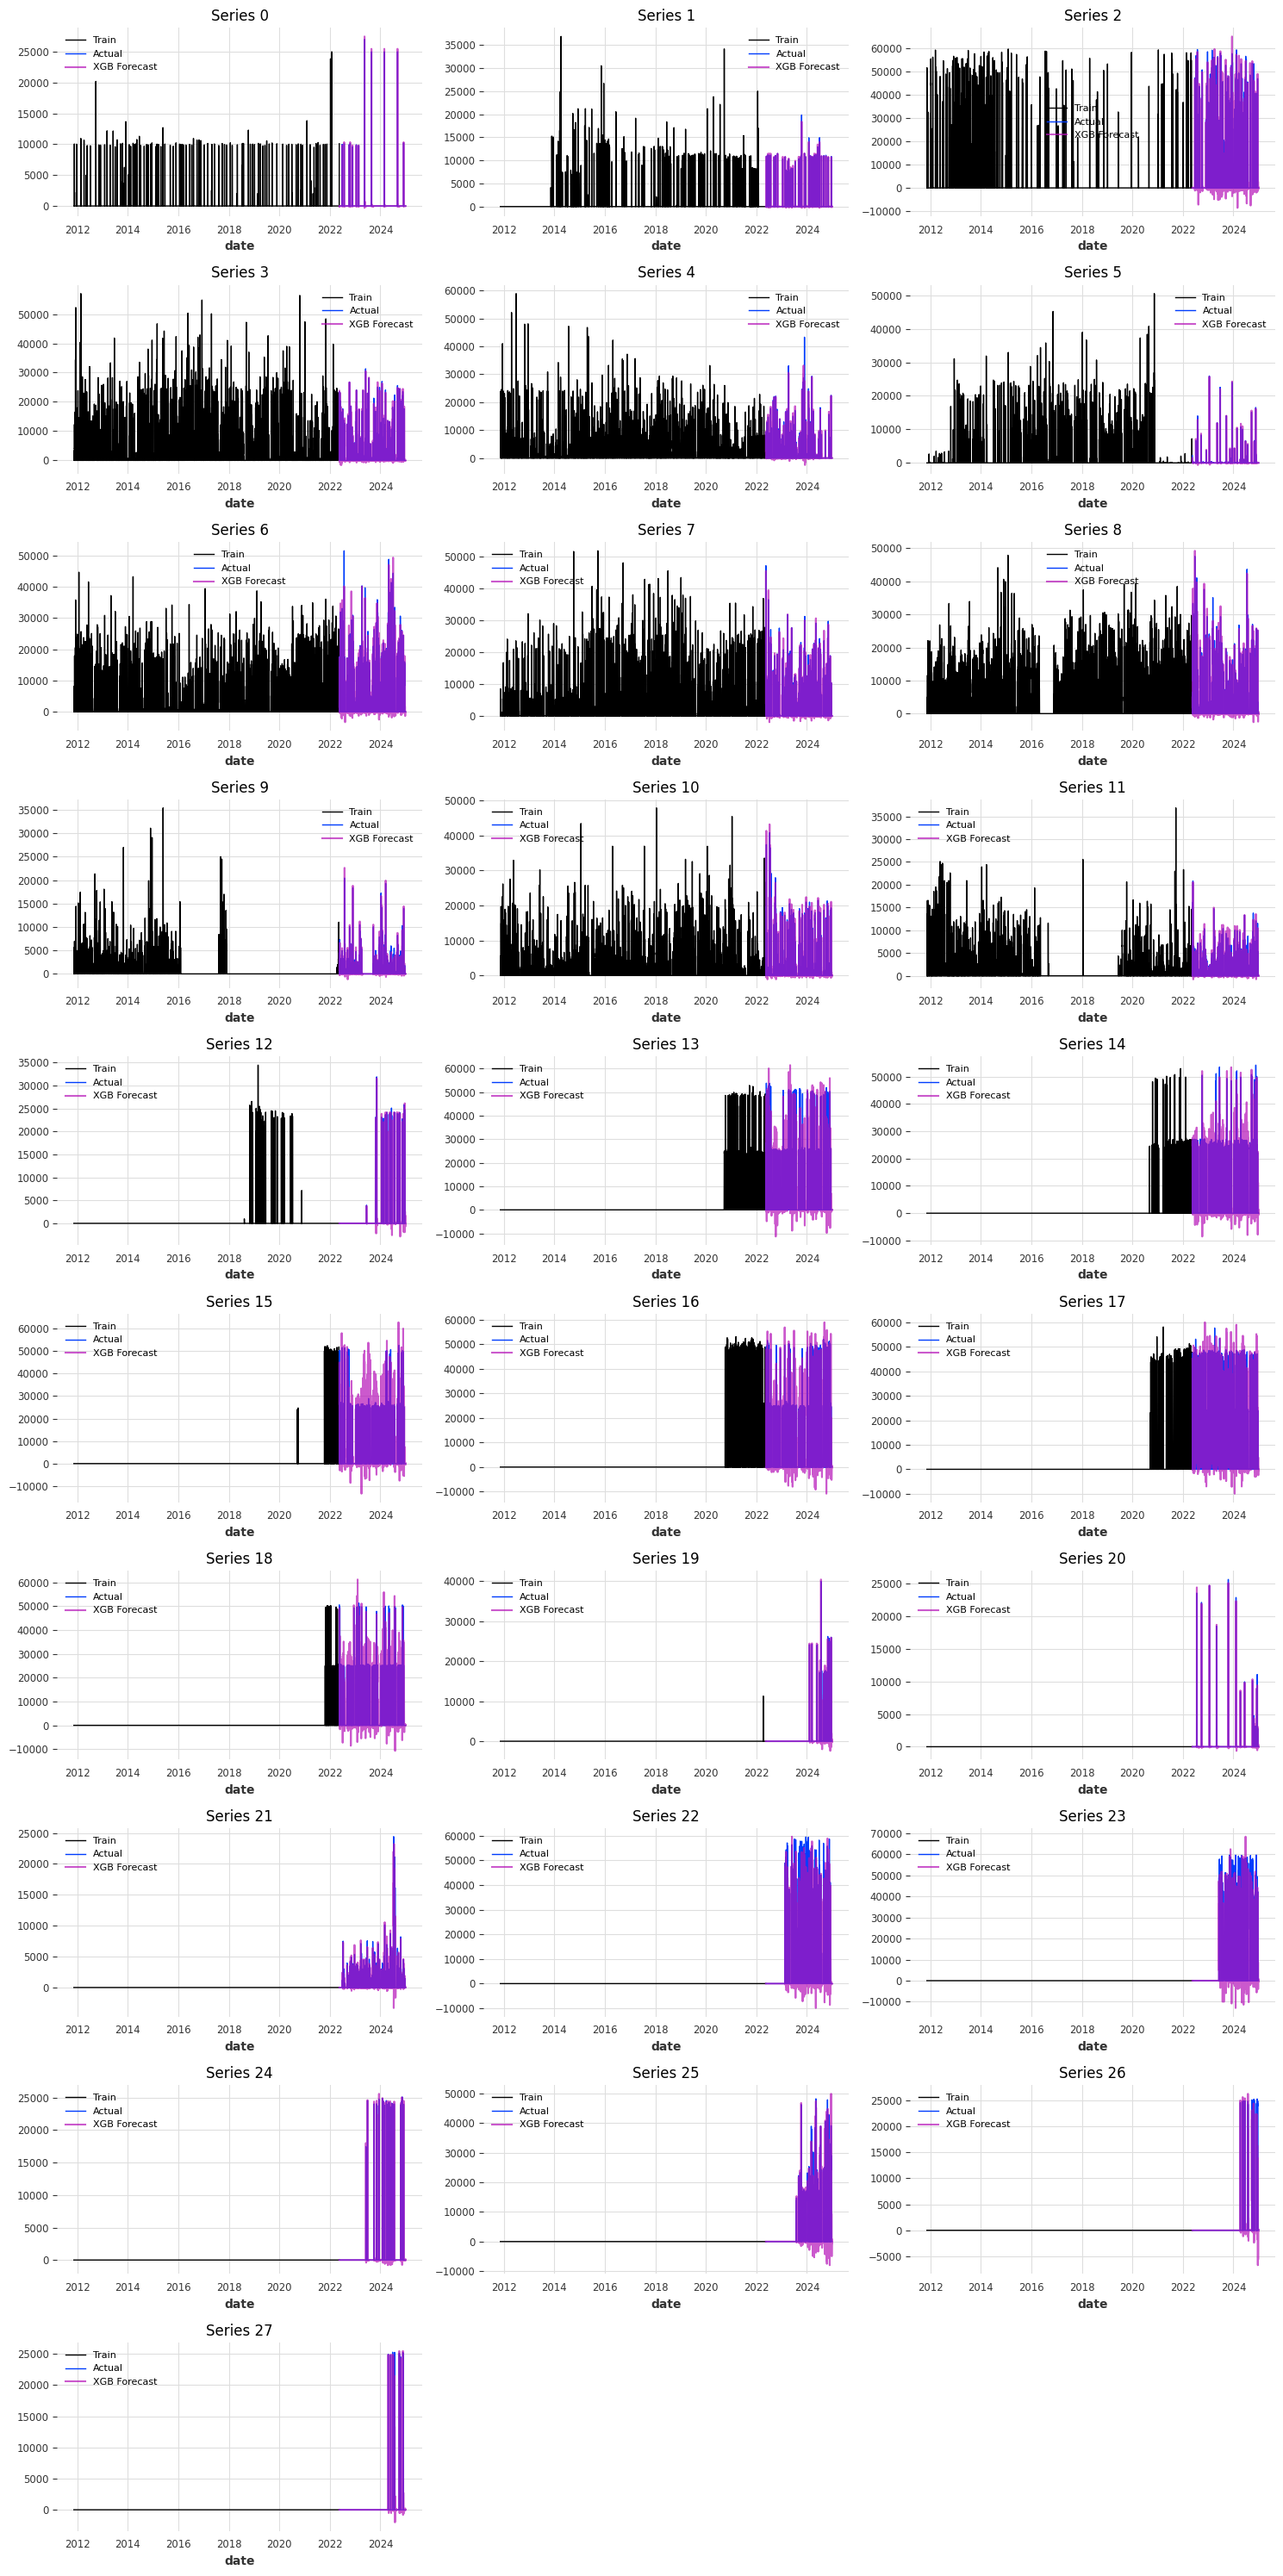

In [ ]:
from darts.utils.callbacks import TFMProgressBar

preds = []

model_xgb = XGBModel(
    lags=32,
    lags_past_covariates=32,
    output_chunk_length=1,
    early_stopping_rounds=50,
    n_estimators=1000,
    random_state=random_state,
    # add_encoders=encoders,
    multi_models=False,
    n_jobs=-1,
)

model_xgb.fit(
    train_lst,
    val_series=val_lst,
    past_covariates=train_past_covariates,
    val_past_covariates=val_past_covariates,
    verbose=True,
)

preds = model_xgb.predict(
    len(val_lst[0]),
    train_lst,
    past_covariates=past_covariates,
)


# Evaluation
print(f"Series {n} | RMSE: {rmse(val_lst, preds)} \n R2: {r2_score(val_lst, preds)}")
# ==============================
# Gemeinsame Subplots am Ende
# ==============================

n = len(preds)
ncols = 3  # anpassen je nach gewünschter Breite
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * nrows), sharex=False)
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(preds):
        ax.axis("off")
        continue
    train_lst[i].plot(ax=ax, label="Train", lw=1)
    val_lst[i].plot(ax=ax, label="Actual", lw=1)
    preds[i].plot(ax=ax, label="XGB Forecast", lw=1.5, alpha=0.7)
    ax.set_title(f"Series {i}")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


### NBeats

In [ ]:
import torch
from torch import nn


class QuantileLoss(nn.Module):
    def __init__(self, quantile: float = 0.2):
        super().__init__()
        self.q = quantile

    def forward(self, preds, target):
        diff = target - preds
        loss = torch.where(diff >= 0, self.q * diff, (1 - self.q) * -diff)
        return loss.mean()

In [ ]:
# from darts.utils.callbacks import TFMProgressBar

# model_dict = {}
# preds = []
# for n in range(len(train_lst)):
#     print(f"Training model for series {n + 1}/{len(train_lst)}")
#     print(f"Series length: {len(train_lst[n])} | Val length: {len(val_lst[n])}")
#     my_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.05,
#         mode="min",
#     )

#     pl_trainer_kwargs = {
#         "callbacks": [my_stopper, TFMProgressBar(enable_train_bar_only=True)],
#         "accelerator": "cpu",
#         "max_epochs": 50,
#     }
#     model_name = f"nbeats_run_{n}"
#     model_nbeats = NBEATSModel(
#         input_chunk_length=32,
#         output_chunk_length=1,
#         generic_architecture=True,
#         nr_epochs_val_period=1,
#         num_stacks=5,
#         batch_size=128,
#         random_state=random_state,
#         model_name=model_name,
#         save_checkpoints=True,
#         force_reset=True,
#         dropout=0.3,
#         pl_trainer_kwargs=pl_trainer_kwargs,
#     )

#     model_nbeats.fit(
#         train_lst[n],
#         val_series=val_lst[n],
#         past_covariates=train_past_covariates[n],
#         val_past_covariates=val_past_covariates[n],
#         n_epochs=10,
#         verbose=True,
#     )

#     model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)
#     model_dict[n] = model_nbeats

#     pred = model_nbeats.predict(
#         len(val_lst[n]),
#         train_lst[n],
#         past_covariates=past_covariates[n],
#     )
#     preds.append(pred)

#     # Evaluation
#     print(
#         f"Series {n} | RMSE: {rmse(val_lst[n], pred):.2f} | R2: {r2_score(val_lst[n], pred):.3f}"
#     )

# # ==============================
# # Gemeinsame Subplots am Ende
# # ==============================

# n = len(preds)
# ncols = 3  # anpassen je nach gewünschter Breite
# nrows = (n + ncols - 1) // ncols

# fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * nrows), sharex=False)
# axes = axes.flatten()

# for i, ax in enumerate(axes):
#     if i >= len(preds):
#         ax.axis("off")
#         continue
#     train_lst[i].plot(ax=ax, label="Train", lw=1)
#     val_lst[i].plot(ax=ax, label="Actual", lw=1, alpha=0.7)
#     preds[i].plot(ax=ax, label="XGB Forecast", lw=1.5)
#     ax.set_title(f"Series {i}")
#     ax.legend(fontsize=8)

# plt.tight_layout()
# plt.show()


#### multiple series at once

In [ ]:
# from darts.utils.callbacks import TFMProgressBar

# preds = []

# my_stopper = EarlyStopping(
#     monitor="val_loss",
#     patience=5,
#     min_delta=0.05,
#     mode="min",
# )

# pl_trainer_kwargs = {
#     "callbacks": [my_stopper, TFMProgressBar(enable_train_bar_only=True)],
#     "accelerator": "cpu",
#     "max_epochs": 50,
# }
# model_name = f"nbeats_run_{n}"
# model_nbeats = NBEATSModel(
#     input_chunk_length=32,
#     output_chunk_length=1,
#     generic_architecture=True,
#     nr_epochs_val_period=1,
#     num_stacks=5,
#     batch_size=128,
#     random_state=random_state,
#     model_name=model_name,
#     save_checkpoints=True,
#     force_reset=True,
#     dropout=0.3,
#     # loss_fn=QuantileLoss(quantile=0.2),
#     pl_trainer_kwargs=pl_trainer_kwargs,
# )

# model_nbeats.fit(
#     train_lst,
#     val_series=val_lst,
#     past_covariates=train_past_covariates,
#     val_past_covariates=val_past_covariates,
#     verbose=True,
# )

# model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)




In [ ]:
# preds = model_nbeats.predict(
#     len(val_lst[0]),
#     train_lst,
#     past_covariates=past_covariates,
# )

# # Evaluation
# print(f"RMSE: {rmse(val_lst, preds)} \n R2: {r2_score(val_lst, preds)}")

# # ==============================
# # Gemeinsame Subplots am Ende
# # ==============================

# n = len(preds)
# ncols = 3  # anpassen je nach gewünschter Breite
# nrows = (n + ncols - 1) // ncols

# fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * nrows), sharex=False)
# axes = axes.flatten()

# for i, ax in enumerate(axes):
#     if i >= len(preds):
#         ax.axis("off")
#         continue
#     train_lst[i].plot(ax=ax, label="Train", lw=1)
#     val_lst[i].plot(ax=ax, label="Actual", lw=1, alpha=0.7)
#     preds[i].plot(ax=ax, label="XGB Forecast", lw=1.5)
#     ax.set_title(f"Series {i}")
#     ax.legend(fontsize=8)

# plt.tight_layout()
# plt.show()

## Write predictions

In [ ]:
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)


min_value_mapper = Mapper(lambda x: np.where(x < 1.0, 0, x))


def extract_past_covs(series_lst):
    past_cov = []
    for series in series_lst:
        trend, seasonal = extract_trend_and_seasonality(
            series, freq=7, model=ModelMode.ADDITIVE
        )
        trend = trend.with_columns_renamed("net_weight", "trend")
        seasonal = seasonal.with_columns_renamed("net_weight", "seasonal")
        covs = concatenate(
            [
                trend,
                seasonal,
            ],
            axis=1,
            ignore_static_covariates=True,
        )
        covs = covs.add_datetime_attribute("day_of_week")
        covs = covs.add_datetime_attribute("month")
        past_cov.append(covs)

    return past_cov


final_predictions = []

n_steps = 150  # assuming daily frequency
for i in range(n_steps):
    covs = extract_past_covs(series_lst)
    pred = model_xgb.predict(1, series_lst, past_covariates=covs)
    pred = min_value_mapper.transform(pred)

    for j in range(len(series_lst)):
        series_lst[j] = series_lst[j].append(pred[j])

    # df = series_lst[-150:].to_dataframe()
    # df["net_weight_cumsum"] = df["net_weight"].cumsum()
    # rm_id = series_lst.static_covariates["rm_id"].values[0]
    # df["rm_id"] = rm_id
    # df["end_date"] = df.index
    # final_predictions.append(df)

# df_final = pd.concat(final_predictions)

<Axes: xlabel='date'>

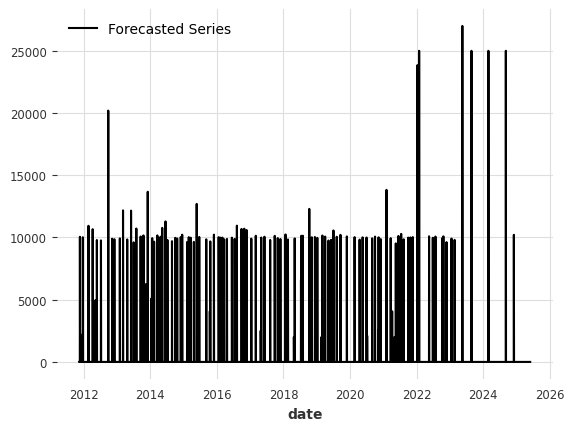

In [ ]:
series_lst[0].plot(label="Forecasted Series", lw=1.5)

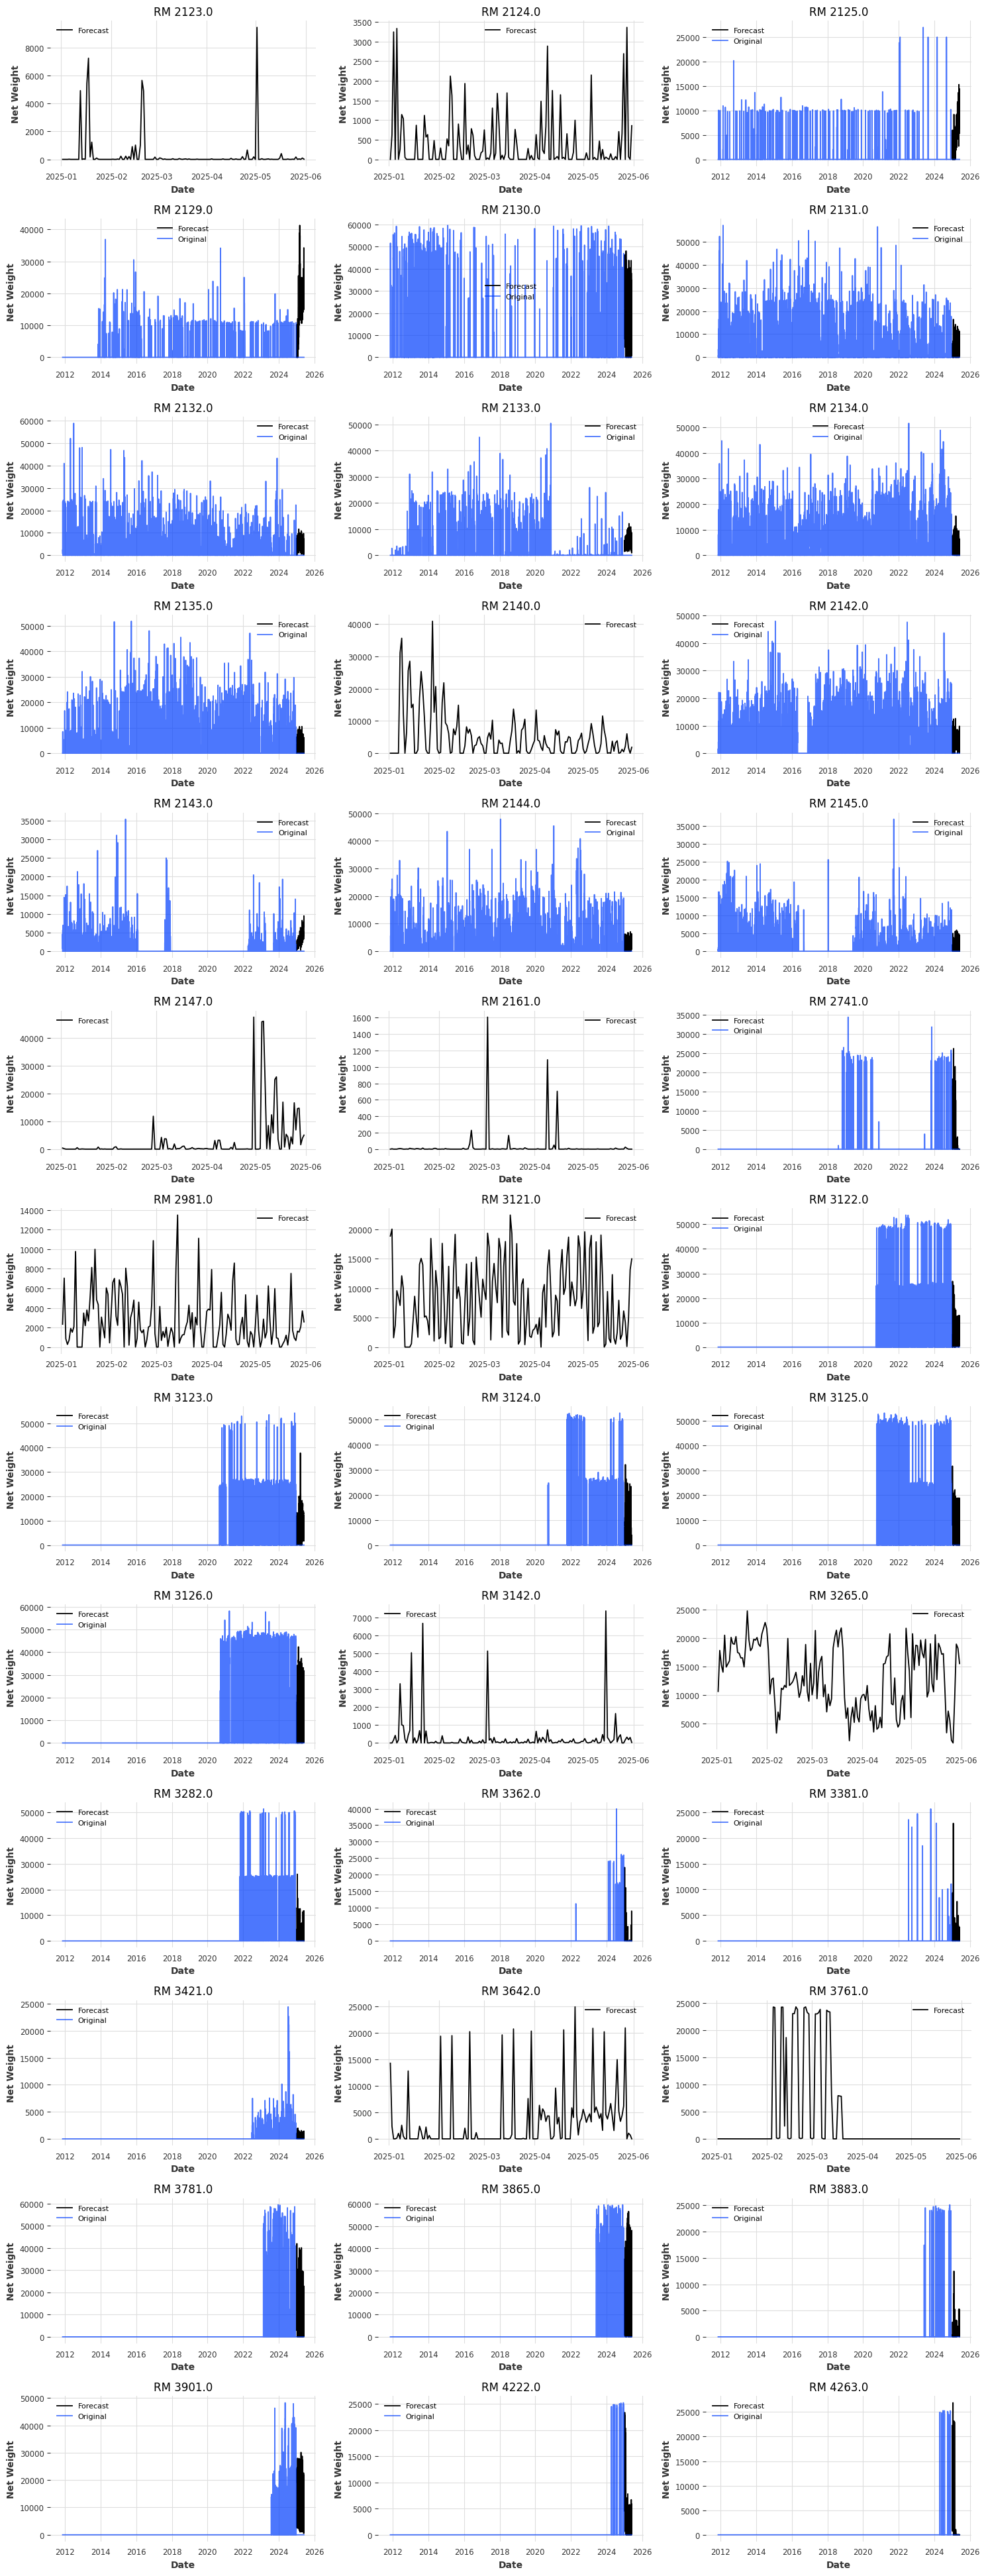

In [ ]:
import matplotlib.pyplot as plt

# final_predictions enthält alle Forecasts
# Sammle die eindeutigen rm_id
rm_ids = df_final["rm_id"].unique()
n_series = len(rm_ids)

# Subplot-Grid
ncols = 3
nrows = (n_series + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * nrows))
axes = axes.flatten()

for i, rm_id in enumerate(rm_ids):
    ax = axes[i]
    df_plot = df_final[df_final["rm_id"] == rm_id]
    ax.plot(df_plot["end_date"], df_plot["net_weight"], label="Forecast")

    # Originalserie extrahieren über series_lst anhand rm_id
    # Wir suchen die Serie, die genau diesen rm_id als static_covariate hat
    orig_series = None
    for s in series_lst:
        if s.static_covariates["rm_id"].values[0] == rm_id:
            orig_series = s
            break
    if orig_series is not None:
        ax.plot(
            orig_series.time_index, orig_series.values(), label="Original", alpha=0.7
        )

    ax.set_title(f"RM {rm_id}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Net Weight")
    ax.legend(fontsize=8)

# Leere Achsen ausblenden
for ax in axes[n_series:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
prediction_mapping = pd.read_csv("./data/prediction_mapping.csv")
prediction_mapping["forecast_start_date"] = (
    pd.to_datetime(prediction_mapping["forecast_start_date"], utc=True)
    .dt.tz_localize(None)
    .dt.normalize()
)
prediction_mapping["forecast_end_date"] = (
    pd.to_datetime(prediction_mapping["forecast_end_date"], utc=True)
    .dt.tz_localize(None)
    .dt.normalize()
)

prediction_mapping = prediction_mapping.sort_values(["rm_id", "forecast_end_date"])
start_date = pd.Timestamp("2025-01-01")

df_submission = (
    prediction_mapping.merge(
        df_final,
        left_on=["rm_id", "forecast_end_date"],
        right_on=["rm_id", "end_date"],
        how="left",
    )
    .rename(columns={"net_weight_cumsum": "predicted_weight"})
    .sort_values("ID")
)
df_submission.fillna(0, inplace=True)
df_submission[["ID", "predicted_weight"]].to_csv("submission.csv", index=False)